In [13]:
import multiprocessing as mp

import numpy as np
import timeit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

from src import parallel_bootstrap
from src import parallel_bootstrap_div


## Bootstrapping example:
The mean of a sample taken from a normal distribution with mean 5 and standard deviation equal to 1. The function takes 
100 samples of size 50. 

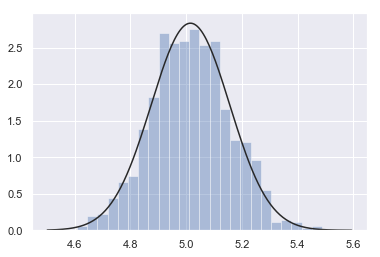

In [2]:
from scipy.stats import norm
sample_normal = np.random.normal(5, 1, 10000)
test = parallel_bootstrap_div.sampling(sample_normal, 1000, 50)
test_result = parallel_bootstrap_div.bootstrap(test, np.mean)

sns.set(style='darkgrid')
sns.distplot(test_result, fit=norm, kde=False)

In [3]:
# Confidence interval of 95% for the mean of the sample
np.percentile(test_result, [2.5, 97.5])

array([4.73063603, 5.28227872])

In [4]:
# For th standard error of the mean of the sample
se = np.std(test_result)
# We expect the mean +- estimated SD
[np.mean(sample_normal) - se, np.mean(sample_normal) + se]


[4.86944951074205, 5.1511256418551215]

## Performance between Serial and Parallel functions
- To construct the serial and the parallel versions of the bootstrapping function we must divide the problem into to major 
processes: the sampling and the statistic estimation. The first process requires to take a sample $i$ (with replacement)  
of size $n_i$ from the original data. The second process is estimating the statistic for the $i$-th sample from the first   
process, this statistic could be the mean, median, variance, among others. Both processes are repeated $n$ times. 
- The result for applying both processes is a distribution of size $n$ of the statistic that tries to replicate the 
population distribution of the statistic. From this distribution we can estimate the confidence interval and the 
standard error to make statistical inference.
- For both cases, serial and parallel, we will create two functions, one that generates the sample without using the 
Numpy module and one that uses the Numpy module to generate it (`numpy.random.choice`). Therefore, we will compare the
performance of 4 functions: serial without Numpy, serial with Numpy, parallel without Numpy, and parallel with Numpy.
- Since running the whole process takes a long time, we will load a `pandas DataFrame` with the results.

In [14]:
data = pd.read_pickle('data/NoNPvsNPv2.pkl')
data_wo = data.loc[:, ['Serial', 'Parallel']]
data_w = data.loc[:, ['SerialNP', 'ParallelNP']]
data_par = pd.read_pickle('data/ParallelNPv2.pkl')
data_div = pd.read_pickle('data/DivPar.pkl')

### Performance without using Numpy
- The following figure shows in the vertical axis the running time of repeating the process (i.e. taking $n$ of samples 
from the original data) a determined number of times (horizontal axis). Both cases show a linear relationship between 
the size of the input (i.e. number of samples) and the running time, indicating a $O(n)$ time complexity. 
- The parallel implementation seems to perform significantly better than the serial one, since it takes, in average, 
 3.72 less time to process a same-size input.    

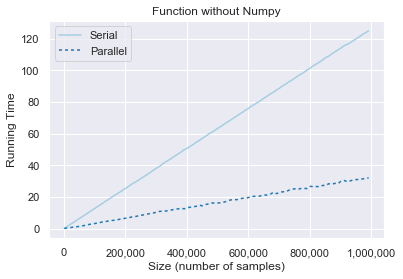

In [15]:
sns.set(style='darkgrid', palette='Paired')
p = sns.lineplot(data=data_wo, dashes=[(None, None), (2, 2)])
p.legend(labels=['Serial', 'Parallel'])
p.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Function without Numpy')
plt.show()

### Performance with Numpy
- The next figure illustrates the results of the serial and parallel function using the Numpy module to improve the 
results. The comparison shows a significant improvement between the serial and the parallel version, even higher than
the non-Numpy version. The serial version shows a time complexity of $O(n)$, just a expected from the previous results. 
Contrarily, the parallel version shows a $O(c)$ time complexity in this graph, meaning that the size of input does not
affect the running time of the algorithm. Moreover, the improvement between the serial and the parallel version is
57 times, in average, faster. In order to confirm these results, we generate a graph with taking into account only the
parallel version of the function. 


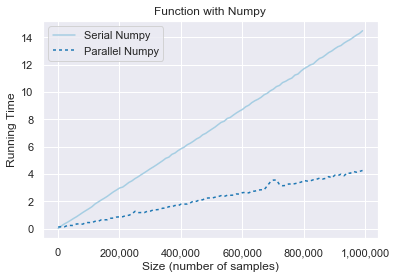

In [16]:
sns.set(style='darkgrid', palette='Paired')
p2 = sns.lineplot(data=data_w, dashes=[(None, None), (2, 2)])
p2.legend(labels=['Serial Numpy', 'Parallel Numpy'])
p2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p2.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Function with Numpy')
plt.show()

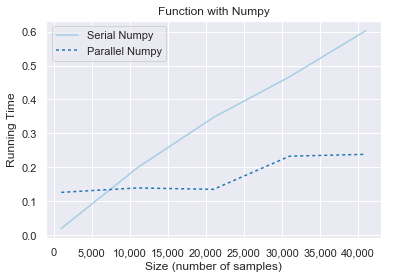

In [19]:
sns.set(style='darkgrid', palette='Paired')
p3 = sns.lineplot(data=data_w.iloc[:5], dashes=[(None, None), (2, 2)])
p3.legend(labels=['Serial Numpy', 'Parallel Numpy'])
p3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p3.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Function with Numpy')
plt.show()


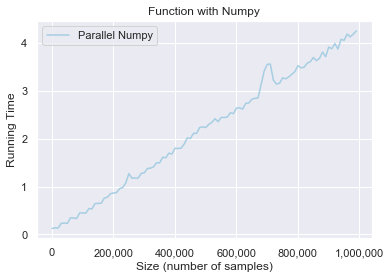

In [18]:
sns.set(style='darkgrid', palette='Paired')
p4 = sns.lineplot(data=data_w.loc[:, 'ParallelNP'], dashes=[(2, 2)])
p4.legend(labels=['Parallel Numpy'])
p4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p4.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Function with Numpy')
plt.show()


- The following figure graphs the running time results for the parallel function with Numpy when the number of samples
goes from 1 sample to 3,000,000 samples. The result shows a combination of time complexities, where the first part of
the graph shows a constant time complexity, then an exponential increment, and, finally, a linear relationship. This 
result suggests that using parallel computing can improve the running time of algorithms but with some limitations.


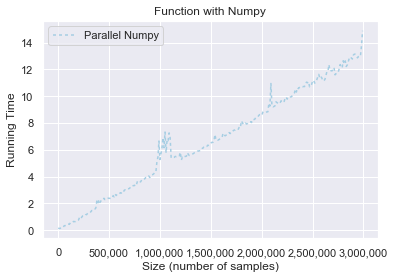

In [10]:
sns.set(style='darkgrid', palette='Paired')
p5 = sns.lineplot(data=data_par, dashes=[(2, 2)])
p5.legend(labels=['Parallel Numpy'])
p5.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p5.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Function with Numpy')
plt.show()

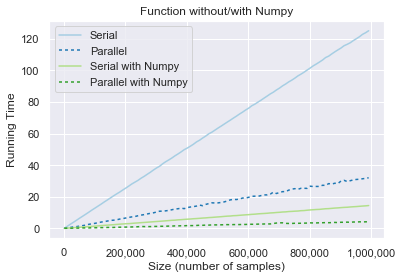

In [11]:
sns.set(style='darkgrid', palette='Paired')
p6 = sns.lineplot(data=data, dashes=[(None, None), (2, 2), (None, None), (2, 2)])
p6.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Function without/with Numpy')
p6.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p6.legend(labels=['Serial', 'Parallel', 'Serial with Numpy', 'Parallel with Numpy'])
plt.show()


### Using Parallel only on simple functions
- For now, we have use parallel computing for the function that accomplishes the process of sampling and the process of
applying the function of the statistic. To understand the limitations of parallel computing in this method, we will
divide the process into two functions, one for sampling and one for applying the function, where the latter will use 
parallel computing. The first function will use Numpy to extract $n$ of samples from the original data and return a list
of Numpy arrays. The second function uses parallel computing to divide the application of the function on the samples 
returned by the first function.
- According to the `multiprocessing` module documentation, the `Pool` class divides the input, i.e. the list of samples,
into equal chunks that are later distributed into the different processes created by the argument `processes`. One could 
assume that this helps to lessen the burden for one processor and diminish running time. Nonetheless, the next figure 
illustrates that using parallel computing not always reaches this conclusion.
- From the graph one can see that both algorithm have a time complexity of $O(n)$, but the Parallel implementation 
takes longer to accomplish the task. When one compares the serial and the parallel function, one can see that the serial
just takes one line of code to accomplish the task, although the this line has a time complexity of $O(n)$. Meanwhile,
the parallel version uses additional steps to create the `pool` object and the processes, therefore the preparation to 
apply the function of the statistic takes more time than the serial implementation. 
- This illustrates a simple case when the running time of simple tasks is not improved by using parallel computing.   

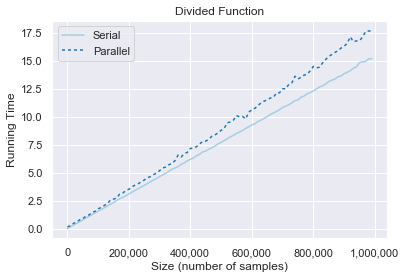

In [12]:
sns.set(style='darkgrid', palette='Paired')
p7 = sns.lineplot(data=data_div, dashes=[(None, None), (2, 2), (None, None), (2, 2)])
p7.set(xlabel = 'Size (number of samples)', ylabel = 'Running Time', title = 'Divided Function')
p7.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
p7.legend(labels=['Serial', 'Parallel'])
plt.show()